Header

In [1]:
import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cupy as cp
import lenspyx
import pysht
from pysht import get_geom
import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

lmax, mmax = 2048, 2048
ll = np.arange(0,lmax)
lldlm = np.arange(0,lmax+1024)
# geominfo = ('tgl',{'lmax': lmax, 'smax':3})
geominfo = ('gl',{'lmax':lmax})
# geominfo = ('cc',{'nphi':1032, 'ntheta':2058})
# geominfo = ('healpix',{'nside': 512})

synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = philm # hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))

Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
Tunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
Tskyalm = synsky.get_sim_sky(0, spin=0, space='alm', field='temperature')

[SHTns 3.6.6] built Mar  1 2024, 11:44:01, id: v3.6.6*,avx512,ishioka,openmp
mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
INFO:: 03-01 12:34:54:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-01 12:34:54:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 03-01 12:34:54:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 03-01 12:34:54:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
 -6.50468410e-08+9.93322861e-09j  6.94855761e-08-1.10898411e-08j]
(1, 2100225) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
  -6.50468410e-08+9.93322861e-09j  6.94855761e-08-1.10898411e-08j]]
[ 0.00000000e+00+0

In [2]:
synsky.lenjob_geominfo
synsky.lenjob_geomlib.name

'gl'

In [3]:
hp.Alm.getlmax(len(philm))

2048

# Check calls

## nuFFT test

### CPU

In [4]:
"""
CPU nuFFT
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}
sht_solver = 'ducc' # 'shtns'
for solver in ['finufft', 'duccnufft']:
    for backend in ['CPU']:
        for mode in ['nuFFT']:
            t = pysht.get_transformer(solver, mode, backend)

            # print("Testing function synthesis_general...")
            # defres = t.synthesis_general(lmax, mmax, Tsky, [0,1], 0, 1e-5, 4, mode='GRAD_ONLY', verbose=1)
            
            # print("Testing function adjoint_synthesis_general...")
            # defres = t.adjoint_synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)
            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("\n----Testing function lenmap2gclm...----")
            defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
            
            print("\n----Testing function lensgclm...----")
            defres = t.lensgclm(Tunl.copy(), spin=0, dlm=dlm, lmax_out=lmax, nthreads=4)

            print('\n\n')

Testing solver=finufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc


----Testing function lenmap2gclm...----

----Testing function lensgclm...----


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc




Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----

----Testing function lenmap2gclm...----

----Testing function lensgclm...----





### GPU

In [6]:
"""
GPU nuFFT
"""
sht_solver = 'ducc' # shtns
for solver in ['cufinufft']:
    for backend in ['GPU']:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)
            # t.set_geometry(geominfo)
            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(gclm=Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)

            print("\n----Testing function lenmap2gclm...----")
            defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
            
            print("\n----Testing function lensgclm...----")
            defres = t.lensgclm(Tunl.copy(), spin=0, lmax_out=lmax, dlm=dlm, nthreads=4)

            # print("Testing function synthesis_general...")
            # defres = t.synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            # print("Testing function adjoint_synthesis_general...")
            # defres = t.adjoint_synthesis_general(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

Testing solver=cufinufft backend=GPU mode=nuFFT...
deflection std is 6.93e-01 amin

----Testing function gclm2lenmap...----
deflection std is 6.93e-01 amin
build_angles

----Testing function lenmap2gclm...----
Nu2u:
  nthreads=4, grid=(4114x4116), oversampled grid=(6400x6400), supp=10, eps=1.000000000000000e-07
  npoints=8851680
  memory overhead: 3.297507762908936e-02GB (index) + 6.103515625000000e-01GB (oversampled grid)

Total wall clock time for nu2u: 0.7271s
|
+- nu2u proper          : 90.93% (0.6612s)
|  |
|  +- spreading            : 64.19% (0.4244s)
|  +- FFT                  : 26.53% (0.1754s)
|  +- zeroing grid         :  5.32% (0.0352s)
|  +- grid correction      :  3.96% (0.0262s)
|  +- allocating grid      :  0.00% (0.0000s)
|  
+- building index       :  8.97% (0.0652s)
+- correction factors   :  0.06% (0.0004s)
+- parameter calculation:  0.00% (0.0000s)

----Testing function lensgclm...----





## SHT test

### CPU

In [7]:

"""
CPU SHT
"""
for solver in ['shtns', 'ducc']:
    for backend in ['CPU']:
        for mode in ['SHT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)(geominfo)

            print("Testing function synthesis_general...")
            defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            print("Testing function adjoint_synthesis_general...")
            if solver == 'shtns':
                m = np.random.random(size=t.constructor.spat_shape)
            else:
                m = Tsky
            defres = t.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

Testing solver=shtns backend=CPU mode=SHT...
Testing function synthesis_general...
Testing function adjoint_synthesis_general...



Testing solver=ducc backend=CPU mode=SHT...
Testing function synthesis_general...
Testing function adjoint_synthesis_general...





### GPU

In [8]:
"""
GPU SHT
"""
for solver in ['shtns']:
    for backend in ['GPU']:
        for mode in ['SHT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)(geominfo)

            print("Testing function synthesis_general...")
            defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            print("Testing function adjoint_synthesis_general...")
            if solver == 'shtns':
                m = np.random.random(size=t.constructor.spat_shape)
            else:
                m = Tsky
            defres = t.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')

Testing solver=shtns backend=GPU mode=SHT...
Testing function synthesis_general...
Testing function adjoint_synthesis_general...





# Check output
## deflection

Testing solver=cufinufft backend=GPU mode=nuFFT...
deflection std is 6.93e-01 amin

----Testing function gclm2lenmap...----
deflection std is 6.93e-01 amin
build_angles



Testing solver=finufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc




Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----



Testing solver=lenspyx backend=CPU mode=nuFFT...
{'sig_d': 0.0002017130653159807, 'dlm': array([ 0.00000000e+00+0.00000000e+00j,  9.76051284e-05+0.00000000e+00j,
        9.24585909e-05+0.00000000e+00j, ...,
       -1.58628394e-11-1.08983534e-11j, -3.17534015e-11+4.84902558e-12j,
        3.39202236e-11-5.41363997e-12j]), 'dclm': None, 'lmax_dlm': 2048, 'mmax_dlm': 2048, 'cacher': <lenspyx.cachers.cacher_mem object at 0x155465e21240>, 'geom': <lenspyx.remapping.utils_geom.Geom object at 0x1554e2d8ab30>, 'pbgeom': <lenspyx.remapping.utils_geom.pbdGeometry object at 0x155447f47430>, 'sht_tr': 4, 'verbosity': 0, 'epsilon': 1e-05, 'single_prec': 0, 'single_prec_ptg': False, 'tim': <lenspyx.utils.timer object at 0x155447e6f910>, 'planned': False, 'plans': {}, '_totalconvolves0': False, 'ofactor': 1.5, '_cis': False}

----Testing function gclm2lenmap...----
[ 0.00000000e+00+0.00000000e+00j  9.7605

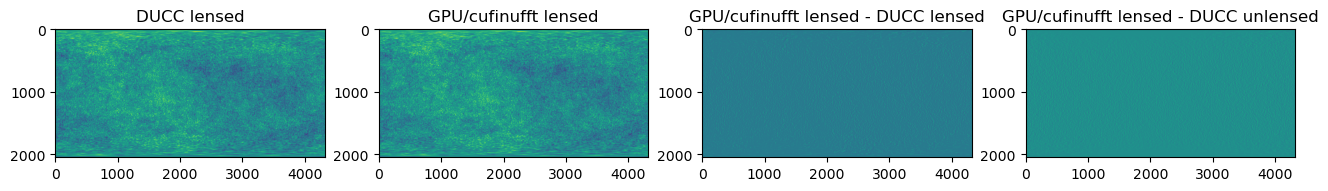

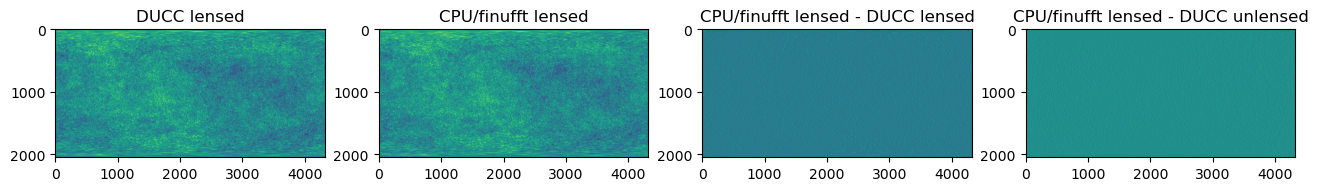

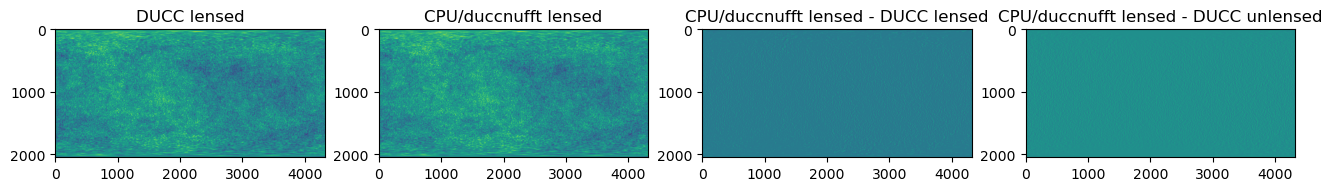

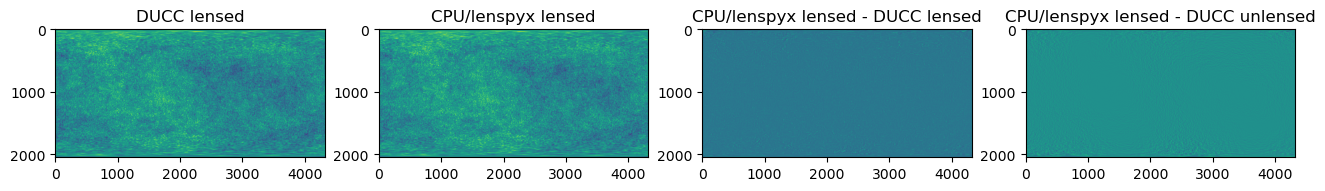

In [9]:
"""
gclm2lenmap
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}


for backend in ['GPU', 'CPU']:
    if backend == 'GPU':
        solvers = ['cufinufft']
    elif backend == 'CPU':
        solvers = ['finufft', 'duccnufft', 'lenspyx']
    sht_solver = 'ducc' # 'shtns'

    for solver in solvers:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            print("\n----Testing function gclm2lenmap...----")
            defres = t.gclm2lenmap(Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            fig, ax = plt.subplots(1,4,figsize=(16,6))
            ax[0].imshow(Tsky.reshape(lmax+1,-1))
            ax[0].set_title('DUCC lensed'.format(solver=solver))
            ax[1].imshow(defres.reshape(lmax+1,-1))
            ax[1].set_title('{backend}/{solver} lensed'.format(solver=solver, backend=backend))
            ax[2].imshow((Tsky-defres).reshape(lmax+1,-1))
            ax[2].set_title('{backend}/{solver} lensed - DUCC lensed'.format(solver=solver, backend=backend))
            ax[3].imshow((Tunlmap-defres).reshape(lmax+1,-1))
            ax[3].set_title('{backend}/{solver} lensed - DUCC unlensed'.format(solver=solver, backend=backend))

            print('\n\n')

Testing solver=lenspyx backend=CPU mode=nuFFT...
{'sig_d': 2.0171306531598067e-28, 'dlm': array([ 0.00000000e+00+0.00000000e+00j,  9.76051284e-29+0.00000000e+00j,
        9.24585909e-29+0.00000000e+00j, ...,
       -1.58628394e-35-1.08983534e-35j, -3.17534015e-35+4.84902558e-36j,
        3.39202236e-35-5.41363997e-36j]), 'dclm': None, 'lmax_dlm': 2048, 'mmax_dlm': 2048, 'cacher': <lenspyx.cachers.cacher_mem object at 0x155447e6f910>, 'geom': <lenspyx.remapping.utils_geom.Geom object at 0x155447e0fd30>, 'pbgeom': <lenspyx.remapping.utils_geom.pbdGeometry object at 0x1554e09df670>, 'sht_tr': 4, 'verbosity': 0, 'epsilon': 1e-05, 'single_prec': 0, 'single_prec_ptg': False, 'tim': <lenspyx.utils.timer object at 0x155465e22e90>, 'planned': False, 'plans': {}, '_totalconvolves0': False, 'ofactor': 1.5, '_cis': False}

----Testing function lenmap2gclm...----
geom name: gl
[ 0.00000000e+00+0.00000000e+00j  9.76051284e-29+0.00000000e+00j
  9.24585909e-29+0.00000000e+00j ... -1.58628394e-35-1.089

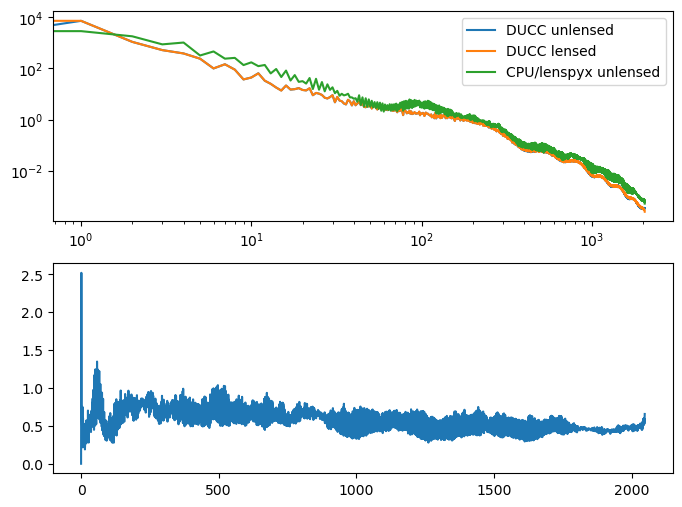

In [10]:
import healpy as hp
"""
lenmap2gclm
"""
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm*1e-24,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False,
    'sht_mode':'GRAD_ONLY'
    }
backend = 'CPU'
if backend == 'GPU':
    solvers = ['cufinufft']
elif backend == 'CPU':
    solvers = ['lenspyx']
sht_solver = 'ducc' # 'shtns'


for solver in solvers:
    fig, ax = plt.subplots(2,1,figsize=(8,6))
    for mode in ['nuFFT']:
        print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
        t = pysht.get_transformer(solver, mode, backend)
        t = t(sht_solver, geominfo, deflection_kwargs)

        print("\n----Testing function lenmap2gclm...----")
        defres = t.lenmap2gclm(points=Tsky.copy(), dlm=dlm, spin=0, lmax=lmax, mmax=lmax, nthreads=4)
        
        ax[0].plot(hp.alm2cl(Tunl), label='DUCC unlensed')
        ax[0].plot(hp.alm2cl(Tskyalm), label='DUCC lensed')
        ax[0].plot(hp.alm2cl(defres)*1e-12, label='{backend}/{solver} unlensed'.format(solver=solver, backend=backend))
        ax[1].plot(hp.alm2cl(Tunl)/hp.alm2cl(defres)*1e12, label='DUCC - {backend}/{solver} unlensed'.format(solver=solver, backend=backend))
    ax[0].loglog()
    ax[0].legend()
    plt.show()

In [ ]:
print(np.mean(dlm), np.mean(t.lenspyx.dlm))

(5.339939459240463e-10+1.627301447237504e-10j) (5.339939459240463e-10+1.627301447237504e-10j)


/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `x` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `y` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/mnt/home/sbelkner/venv/pysht/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduc

** gclm2lenmap: inconsistent input dtype !
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
 -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
(1, 2100225) complex128 [[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
   2.26476370e-04+0.00000000e+00j ... -3.24791627e-08-2.23143778e-08j
  -0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]
deflection std is 2.64e+00 amin
deflection std is 2.64e+00 amin
build_angles


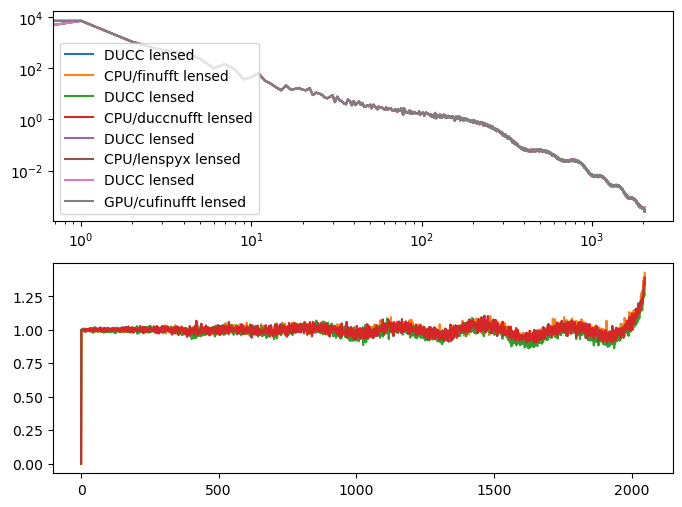

In [ ]:
deflection_kwargs = {
    'nthreads': 4,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

fig, ax = plt.subplots(2,1,figsize=(8,6))
for backend in ['CPU', 'GPU']:
    if backend == 'GPU':
        solvers = ['cufinufft']
    elif backend == 'CPU':
        solvers = ["finufft", "duccnufft", "lenspyx"] #   
    sht_solver = 'ducc' # 'shtns'
    for solver in solvers:
        for mode in ['nuFFT']:
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            defres = t.lensgclm(Tunl.copy(), spin=0, dlm=dlm, lmax_out=lmax, nthreads=4)
                
            ax[0].plot(hp.alm2cl(Tunl), label='DUCC lensed')
            ax[0].plot(hp.alm2cl(defres.astype(complex)), label='{backend}/{solver} lensed'.format(solver=solver, backend=backend))
            ax[1].plot(hp.alm2cl(Tunl)/hp.alm2cl(defres.astype(complex)), label='DUCC - {backend}/{solver} lensed'.format(solver=solver, backend=backend))
        ax[0].loglog()
        ax[0].legend()
plt.show()

## SHT

In [ ]:
backend = 'CPU'
if backend == 'GPU':
    solvers = ['shtns']
elif backend == 'CPU':
    solvers = ['ducc', 'duccnufft']
sht_solver = 'ducc' # 'shtns'

for solver in solvers:
    for mode in ['SHT']:
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            defres = t.synthesis(Tunl.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            
            fig, ax = plt.subplots(1,4,figsize=(16,6))
            ax[0].imshow(Tsky.reshape(lmax+1,-1))
            ax[0].set_title('DUCC lensed'.format(solver=solver))
            ax[1].imshow(defres.reshape(lmax+1,-1))
            ax[1].set_title('{solver} lensed'.format(solver=solver))
            ax[2].imshow((Tsky-defres).reshape(lmax+1,-1))
            ax[2].set_title('{solver} lensed - DUCC lensed'.format(solver=solver))
            ax[3].imshow((Tunlmap-defres).reshape(lmax+1,-1))
            ax[3].set_title('{solver} lensed - DUCC unlensed'.format(solver=solver))
            
            print('\n\n')

In [ ]:
backend = ['CPU']
if backend == 'GPU':
    solvers = ['cufinufft']
elif backend == 'CPU':
    solvers = ['finufft', 'duccnufft']
sht_solver = 'ducc' # 'shtns'

for solver in solvers:
    for mode in ['SHT']:
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            if solver == 'shtns':
                m = np.random.random(size=t.constructor.spat_shape)
            else:
                m = Tsky
            defres = t.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=4)
            print('\n\n')
            
            fig, ax = plt.subplots(1,4,figsize=(16,6))
            ax[0].imshow(Tsky.reshape(lmax+1,-1))
            ax[0].set_title('DUCC lensed'.format(solver=solver))
            ax[1].imshow(defres.reshape(lmax+1,-1))
            ax[1].set_title('{solver} lensed'.format(solver=solver))
            ax[2].imshow((Tsky-defres).reshape(lmax+1,-1))
            ax[2].set_title('{solver} lensed - DUCC lensed'.format(solver=solver))
            ax[3].imshow((Tunlmap-defres).reshape(lmax+1,-1))
            ax[3].set_title('{solver} lensed - DUCC unlensed'.format(solver=solver))
            

            
            # print("\n----Testing function lensgclm...----")
            # defres = t.lensgclm(Tunl.copy(), spin=0, dlm=dlm, lmax_out=lmax, nthreads=4)

            print('\n\n')